![image.png](images/ensemble_learning.png)

**强可学习和弱可学习**  
在PAC（概率近似正确）学习的框架下：  
一个概念（类），如果存在一个多项式的学习算法能够学习它，并且正确率很高，那么就称这个**概念**是**强可学习**的；  
一个概念（类），如果存在一个多项式的学习算法能够学习它，学习的正确率仅比随机猜测略好，那么就称这个**概念**是**弱可学习**的； 

同时，**一个概念是强可学习的充要条件是这个概念是弱可学习的。**  

通常，弱学习算法比强学习算法容易的多；那如何将弱学习算法提升到强学习算法呢？

最具代表性的就是**AdaBoost**.

**AdaBoost的原理：**  
1，提高前一轮被错误分类的样本权重，降低前一轮正确分类的样本权重  
2，对各个弱分类器进行加权投票的方式集成

**AdaBoost算法步骤：**  
**首先明确几个用到的概念：**  
* 样本集（样本数为n）
* w (样本权重，样本集中每个样本都有对应的权重)  
* $\alpha$  (模型权重，弱学习器的模型权重)
* e (弱学习器的错误率)

**第一轮训练**  
* **1.初始样本权重**  
$w_1=[\frac{1}{n} …… \frac{1}{n}](共n项)$
* **2.计算错误率**  
$e_1 = \sum_{i=1}^n w_{1,i}I(h_m(x)\ne y_i)$  
* **3.计算模型一权重**  
$\alpha_1 = \frac{1}{2}\lg(\frac{1-e_1}{e_1})$  

**第二轮训练**  
* **1.更新样本权重**  
$Z_1=\sum_{1}^n w_{1,i}exp(-y_i\alpha_i h_i(x_i))$  
$w_{2,i} = \frac{w_{1,i}}{Z_1}exp(-y_i\alpha_i h_i(x_i)$  
* **2.计算错误率**  
$e_2 = \sum_{i=1}^n w_{2,i}I(h_m(x)\ne y_i)$  
* **3.计算模型一权重**  
$\alpha_2 = \frac{1}{2}\lg(\frac{1-e_2}{e_2})$

**第三轮训练**  
* **1.更新样本权重**  
$Z_2=\sum_{1}^n w_{2,i}exp(-y_i\alpha_i h_i(x_i))$  
$w_{3,i} = \frac{w_{2,i}}{Z_2}exp(-y_i\alpha_i h_i(x_i)$  
* **2.计算错误率**  
$e_3 = \sum_{i=1}^n w_{3,i}I(h_m(x)\ne y_i)$  
* **3.计算模型一权重**  
$\alpha_3 = \frac{1}{2}\lg(\frac{1-e_3}{e_3})$

**最终集成模型**  
$H(x) = sign(\sum_{m=1}^3 \alpha_m h_m(x))$

## 葡萄酒数据集

该数据集包含了178个样本和13个特征，我们的任务是根据这些数据预测红酒属于哪一个类别。
https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data 

In [18]:
# 导入库
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score

**数据处理**

In [7]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data"
wine = pd.read_csv(url)
wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash','Magnesium', 'Total phenols','Flavanoids', 'Nonflavanoid phenols', 
                'Proanthocyanins','Color intensity', 'Hue','OD280/OD315 of diluted wines','Proline']

In [9]:
print(wine['Class label'].value_counts())
wine.head()

2    71
1    58
3    48
Name: Class label, dtype: int64


,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
1,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
2,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
3,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735
4,1,14.20,1.76,2.45,15.2,112,3.27,3.39,0.34,1.97,6.75,1.05,2.85,1450


In [13]:
# 数据预处理
# 去除标签分类1的数据，仅考虑二分类
# 目前只取两个特征
wine = wine[wine['Class label']!=1]
y = wine['Class label'].values
X = wine[['Alcohol','OD280/OD315 of diluted wines']].values

# 标签转为二进制编码
le = LabelEncoder()
y = le.fit_transform(y)

# 拆分验证集和测试机
# stratify参数代表了按照y的类别等比例抽样
X_train,X_test,y_train,y_test = train_test_split(X,y,
                                                 test_size=0.2,
                                                 random_state=1,
                                                 stratify=y)

**模型训练**

In [20]:
#决策树基模型
tree = DecisionTreeClassifier(criterion='entropy', random_state=1, max_depth=1)
tree = tree.fit(X_train, y_train)

# predict
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)
tree_train = accuracy_score(y_train,y_train_pred)
tree_test = accuracy_score(y_test,y_test_pred)
print('Decision tree train/test accuracies %.3f/%.3f' % (tree_train,tree_test))

Decision tree train/test accuracies 0.916/0.875


In [21]:
# Adaboost
ada = AdaBoostClassifier(base_estimator=tree, n_estimators=500, 
                         learning_rate=0.1,
                         random_state=1
                        )
ada = ada.fit(X_train, y_train)

# predict
y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)
ada_train = accuracy_score(y_train,y_train_pred)
ada_test = accuracy_score(y_test,y_test_pred)
print('Adaboost train/test accuracies %.3f/%.3f' % (ada_train,ada_test))

Adaboost train/test accuracies 1.000/0.917


**显然，AdaBoost优于决策树模型。  
但训练集和测试集之间的性能相差比较大，下面用决策边界的图像来解释。**

**决策边界**

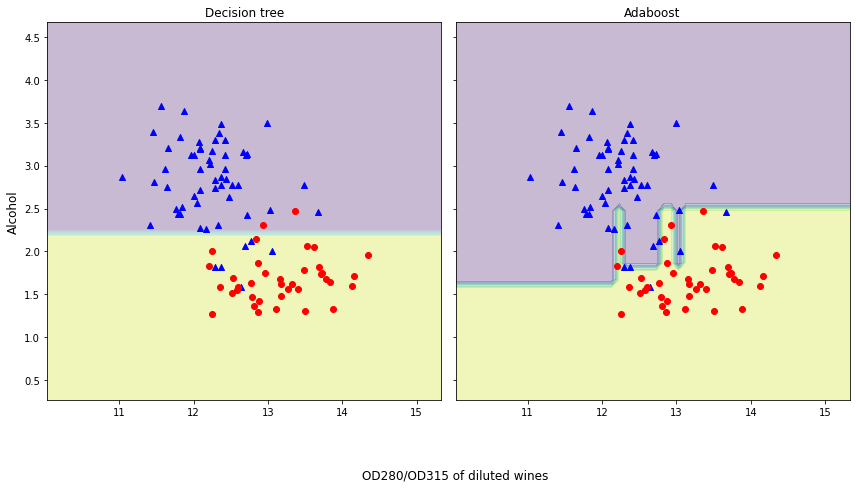

In [22]:
# 画出单层决策树与Adaboost的决策边界：
x_min = X_train[:, 0].min() - 1
x_max = X_train[:, 0].max() + 1
y_min = X_train[:, 1].min() - 1
y_max = X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),np.arange(y_min, y_max, 0.1))
f, axarr = plt.subplots(nrows=1, ncols=2,sharex='col',sharey='row',figsize=(12, 6))
for idx, clf, tt in zip([0, 1],[tree, ada],['Decision tree', 'Adaboost']):
    clf.fit(X_train, y_train)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    axarr[idx].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx].scatter(X_train[y_train==0, 0],X_train[y_train==0, 1],c='blue', marker='^')
    axarr[idx].scatter(X_train[y_train==1, 0],X_train[y_train==1, 1],c='red', marker='o')
    axarr[idx].set_title(tt)
axarr[0].set_ylabel('Alcohol', fontsize=12)
plt.tight_layout()
plt.text(0, -0.2,s='OD280/OD315 of diluted wines',ha='center',va='center',fontsize=12,transform=axarr[1].transAxes)
plt.show()

**从图中可以看出，AdaBoost 的决策边界要复杂的多；显然，AdaBoost提升了模型复杂度，出现了过拟合，导致训练集和测试集相差挺大。**